**Chapter 9 – Up and running with TensorFlow**

_This notebook contains all the sample code and solutions to the exercises in chapter 9._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Creating and running a graph

In [3]:
import tensorflow as tf

reset_graph()

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [4]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [6]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [7]:
sess.close()

In [8]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

In [9]:
result

42

In [10]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    result = f.eval()

In [11]:
result

42

In [12]:
init = tf.global_variables_initializer()

In [13]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)

42


In [14]:
sess.close()

In [15]:
result

42

# Managing graphs

In [16]:
reset_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [17]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [18]:
x2.graph is tf.get_default_graph()

False

In [19]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [20]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# Linear Regression

## Using the Normal Equation

In [21]:
import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [22]:
theta_value

array([[ -3.74651413e+01],
       [  4.35734153e-01],
       [  9.33829229e-03],
       [ -1.06622010e-01],
       [  6.44106984e-01],
       [ -4.25131839e-06],
       [ -3.77322501e-03],
       [ -4.26648885e-01],
       [ -4.40514028e-01]], dtype=float32)

Compare with pure NumPy

In [23]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654266e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


Compare with Scikit-Learn

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654265e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


/Users/jonzink/miniconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## Using Batch Gradient Descent

Gradient Descent requires scaling the feature vectors first. We could do this using TF, but let's just use Scikit-Learn for now.

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [26]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[  1.00000000e+00   6.60969987e-17   5.50808322e-18   6.60969987e-17
  -1.06030602e-16  -1.10161664e-17   3.44255201e-18  -1.07958431e-15
  -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ..., -0.06612179 -0.06360587
  0.01359031]
0.111111111111
(20640, 9)


### Manually computing the gradients

In [28]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147


In [29]:
best_theta

array([[ 2.06855249],
       [ 0.88740271],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393812],
       [-0.04269557],
       [-0.66145277],
       [-0.63752776]], dtype=float32)

### Using autodiff

Same as above except for the `gradients = ...` line:

In [30]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [31]:
gradients = tf.gradients(mse, [theta])[0]

In [32]:
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147
Best theta:
[[ 2.06855249]
 [ 0.88740271]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145277]
 [-0.6375277 ]]


How could you find the partial derivatives of the following function with regards to `a` and `b`?

In [33]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

In [34]:
my_func(0.2, 0.3)

-0.21253923284754916

In [35]:
reset_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)

grads = tf.gradients(z, [a, b])
init = tf.global_variables_initializer()

Let's compute the function at $a=0.2$ and $b=0.3$, and the partial derivatives at that point with regards to $a$ and with regards to $b$:

In [37]:
with tf.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.212537
[-1.1388494, 0.19671395]


### Using a `GradientDescentOptimizer`

In [34]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [35]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

In [36]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147
Best theta:
[[ 2.06855249]
 [ 0.88740271]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145277]
 [-0.6375277 ]]


### Using a momentum optimizer

In [37]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [38]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

In [39]:
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [40]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Best theta:
[[ 2.06855798]
 [ 0.82962859]
 [ 0.11875337]
 [-0.26554456]
 [ 0.30571091]
 [-0.00450251]
 [-0.03932662]
 [-0.89986444]
 [-0.87052065]]


# Feeding data to the training algorithm

## Placeholder nodes

In [41]:
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)

[[ 6.  7.  8.]]


In [42]:
print(B_val_2)

[[  9.  10.  11.]
 [ 12.  13.  14.]]


## Mini-batch Gradient Descent

In [43]:
n_epochs = 1000
learning_rate = 0.01

In [44]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [45]:
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [46]:
n_epochs = 10

In [47]:
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [48]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(m, size=batch_size)  # not shown
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

In [49]:
best_theta

array([[ 2.07033372],
       [ 0.86371452],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.80304712]], dtype=float32)

# Saving and restoring a model

In [50]:
reset_graph()

n_epochs = 1000                                                                       # not shown in the book
learning_rate = 0.01                                                                  # not shown

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # not shown
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            # not shown
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      # not shown
error = y_pred - y                                                                    # not shown
mse = tf.reduce_mean(tf.square(error), name="mse")                                    # not shown
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            # not shown
training_op = optimizer.minimize(mse)                                                 # not shown

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                                # not shown
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147


In [51]:
best_theta

array([[ 2.06855249],
       [ 0.88740271],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145277],
       [-0.6375277 ]], dtype=float32)

In [52]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval() # not shown in the book

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [53]:
np.allclose(best_theta, best_theta_restored)

True

If you want to have a saver that loads and restores `theta` with a different name, such as `"weights"`:

In [54]:
saver = tf.train.Saver({"weights": theta})

By default the saver also saves the graph structure itself in a second file with the extension `.meta`. You can use the function `tf.train.import_meta_graph()` to restore the graph structure. This function loads the graph into the default graph and returns a `Saver` that can then be used to restore the graph state (i.e., the variable values):

In [55]:
reset_graph()
# notice that we start with an empty graph.

saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")  # this loads the graph structure
theta = tf.get_default_graph().get_tensor_by_name("theta:0") # not shown in the book

with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")  # this restores the graph's state
    best_theta_restored = theta.eval() # not shown in the book

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [56]:
np.allclose(best_theta, best_theta_restored)

True

This means that you can import a pretrained model without having to have the corresponding Python code to build the graph. This is very handy when you keep tweaking and saving your model: you can load a previously saved model without having to search for the version of the code that built it.

# Visualizing the graph
## inside Jupyter

In [38]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [39]:
show_graph(tf.get_default_graph())

## Using TensorBoard

In [40]:
reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [41]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [42]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [43]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [44]:
with tf.Session() as sess:                                                        # not shown in the book
    sess.run(init)                                                                # not shown

    for epoch in range(n_epochs):                                                 # not shown
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()                                                     # not shown

NameError: name 'fetch_batch' is not defined

In [45]:
file_writer.close()

In [46]:
best_theta

array([[ 2.06855249],
       [ 0.88740271],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145277],
       [-0.6375277 ]], dtype=float32)

# Name scopes

In [47]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [48]:
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [49]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [69]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.07033372]
 [ 0.86371452]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.80304712]]


In [50]:
print(error.op.name)

loss/sub


In [51]:
print(mse.op.name)

loss/mse


In [52]:
reset_graph()

a1 = tf.Variable(0, name="a")      # name == "a"
a2 = tf.Variable(0, name="a")      # name == "a_1"

with tf.name_scope("param"):       # name == "param"
    a3 = tf.Variable(0, name="a")  # name == "param/a"

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


# Modularity

An ugly flat code:

In [53]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z1, 0., name="relu2")  # Oops, cut&paste error! Did you spot it?

output = tf.add(relu1, relu2, name="output")

Much better, using a function to build the ReLUs:

In [54]:
reset_graph()

def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [75]:
file_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

Even better using name scopes:

In [55]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")    # not shown
        b = tf.Variable(0.0, name="bias")                             # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                      # not shown
        return tf.maximum(z, 0., name="max")                          # not shown

In [56]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())
file_writer.close()

## Sharing Variables

Sharing a `threshold` variable the classic way, by defining it outside of the `relu()` function then passing it as a parameter:

In [57]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

In [58]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, relu.threshold, name="max")

In [59]:
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [60]:
reset_graph()

with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

In [61]:
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

In [62]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

In [63]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

In [85]:
file_writer = tf.summary.FileWriter("logs/relu6", tf.get_default_graph())
file_writer.close()

In [86]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu"):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # create the shared variable
    scope.reuse_variables()  # then reuse it
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu8", tf.get_default_graph())
file_writer.close()

In [87]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
    b = tf.Variable(0.0, name="bias")                           # not shown
    z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [88]:
file_writer = tf.summary.FileWriter("logs/relu9", tf.get_default_graph())
file_writer.close()

# Extra material

In [89]:
reset_graph()

with tf.variable_scope("my_scope"):
    x0 = tf.get_variable("x", shape=(), initializer=tf.constant_initializer(0.))
    x1 = tf.Variable(0., name="x")
    x2 = tf.Variable(0., name="x")

with tf.variable_scope("my_scope", reuse=True):
    x3 = tf.get_variable("x")
    x4 = tf.Variable(0., name="x")

with tf.variable_scope("", default_name="", reuse=True):
    x5 = tf.get_variable("my_scope/x")

print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)
print("x3:", x3.op.name)
print("x4:", x4.op.name)
print("x5:", x5.op.name)
print(x0 is x3 and x3 is x5)

x0: my_scope/x
x1: my_scope/x_1
x2: my_scope/x_2
x3: my_scope/x
x4: my_scope_1/x
x5: my_scope/x
True


The first `variable_scope()` block first creates the shared variable `x0`, named `my_scope/x`. For all operations other than shared variables (including non-shared variables), the variable scope acts like a regular name scope, which is why the two variables `x1` and `x2` have a name with a prefix `my_scope/`. Note however that TensorFlow makes their names unique by adding an index: `my_scope/x_1` and `my_scope/x_2`.

The second `variable_scope()` block reuses the shared variables in scope `my_scope`, which is why `x0 is x3`. Once again, for all operations other than shared variables it acts as a named scope, and since it's a separate block from the first one, the name of the scope is made unique by TensorFlow (`my_scope_1`) and thus the variable `x4` is named `my_scope_1/x`.

The third block shows another way to get a handle on the shared variable `my_scope/x` by creating a `variable_scope()` at the root scope (whose name is an empty string), then calling `get_variable()` with the full name of the shared variable (i.e. `"my_scope/x"`).

## Strings

In [90]:
reset_graph()

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

[b'Do' b'you' b'want' b'some' b'caf\xc3\xa9?']


## Implementing a Home-Made Computation Graph

In [64]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self):
        return self.value
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, init_value, name):
        self.value = init_value
        self.name = name
    def evaluate(self):
        return self.value
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self):
        return self.a.evaluate() + self.b.evaluate()
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self):
        return self.a.evaluate() * self.b.evaluate()
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var(3, name="x")
y = Var(4, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2
print("f(x,y) =", f)
print("f(3,4) =", f.evaluate())

f(x,y) = ((x) * (x)) * (y) + y + 2
f(3,4) = 42


## Computing gradients
### Mathematical differentiation

In [92]:
df_dx = Mul(Const(2), Mul(x, y))  # df/dx = 2xy
df_dy = Add(Mul(x, x), Const(1))  # df/dy = x² + 1
print("df/dx(3,4) =", df_dx.evaluate())
print("df/dy(3,4) =", df_dy.evaluate())

df/dx(3,4) = 24
df/dy(3,4) = 10


### Numerical differentiation

In [93]:
def gradients(func, vars_list, eps=0.0001):
    partial_derivatives = []
    base_func_eval = func.evaluate()
    for var in vars_list:
        original_value = var.value
        var.value = var.value + eps
        tweaked_func_eval = func.evaluate()
        var.value = original_value
        derivative = (tweaked_func_eval - base_func_eval) / eps
        partial_derivatives.append(derivative)
    return partial_derivatives

df_dx, df_dy = gradients(f, [x, y])
print("df/dx(3,4) =", df_dx)
print("df/dy(3,4) =", df_dy)

df/dx(3,4) = 24.000400000048216
df/dy(3,4) = 10.000000000047748


### Symbolic differentiation

In [94]:
Const.derive = lambda self, var: Const(0)
Var.derive = lambda self, var: Const(1) if self is var else Const(0)
Add.derive = lambda self, var: Add(self.a.derive(var), self.b.derive(var))
Mul.derive = lambda self, var: Add(Mul(self.a, self.b.derive(var)), Mul(self.a.derive(var), self.b))

x = Var(3.0, name="x")
y = Var(4.0, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2

df_dx = f.derive(x)  # 2xy
df_dy = f.derive(y)  # x² + 1
print("df/dx(3,4) =", df_dx.evaluate())
print("df/dy(3,4) =", df_dy.evaluate())

df/dx(3,4) = 24.0
df/dy(3,4) = 10.0


### Automatic differentiation (autodiff) – forward mode

In [95]:
class DualNumber(object):
    def __init__(self, value=0.0, eps=0.0):
        self.value = value
        self.eps = eps
    def __add__(self, b):
        return DualNumber(self.value + self.to_dual(b).value,
                          self.eps + self.to_dual(b).eps)
    def __radd__(self, a):
        return self.to_dual(a).__add__(self)
    def __mul__(self, b):
        return DualNumber(self.value * self.to_dual(b).value,
                          self.eps * self.to_dual(b).value + self.value * self.to_dual(b).eps)
    def __rmul__(self, a):
        return self.to_dual(a).__mul__(self)
    def __str__(self):
        if self.eps:
            return "{:.1f} + {:.1f}ε".format(self.value, self.eps)
        else:
            return "{:.1f}".format(self.value)
    def __repr__(self):
        return str(self)
    @classmethod
    def to_dual(cls, n):
        if hasattr(n, "value"):
            return n
        else:
            return cls(n)

$3 + (3 + 4 \epsilon) = 6 + 4\epsilon$

In [96]:
3 + DualNumber(3, 4)

6.0 + 4.0ε

$(3 + 4ε)\times(5 + 7ε) = 3 \times 5 + 3 \times 7ε + 4ε \times 5 + 4ε \times 7ε = 15 + 21ε + 20ε + 28ε^2 = 15 + 41ε + 28 \times 0 = 15 + 41ε$

In [97]:
DualNumber(3, 4) * DualNumber(5, 7)

15.0 + 41.0ε

In [98]:
x.value = DualNumber(3.0)
y.value = DualNumber(4.0)

f.evaluate()

42.0

In [99]:
x.value = DualNumber(3.0, 1.0)  # 3 + ε
y.value = DualNumber(4.0)       # 4

df_dx = f.evaluate().eps

x.value = DualNumber(3.0)       # 3
y.value = DualNumber(4.0, 1.0)  # 4 + ε

df_dy = f.evaluate().eps

In [100]:
df_dx

24.0

In [101]:
df_dy

10.0

### Autodiff – Reverse mode

In [102]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self):
        return self.value
    def backpropagate(self, gradient):
        pass
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, init_value, name):
        self.value = init_value
        self.name = name
        self.gradient = 0
    def evaluate(self):
        return self.value
    def backpropagate(self, gradient):
        self.gradient += gradient
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self):
        self.value = self.a.evaluate() + self.b.evaluate()
        return self.value
    def backpropagate(self, gradient):
        self.a.backpropagate(gradient)
        self.b.backpropagate(gradient)
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self):
        self.value = self.a.evaluate() * self.b.evaluate()
        return self.value
    def backpropagate(self, gradient):
        self.a.backpropagate(gradient * self.b.value)
        self.b.backpropagate(gradient * self.a.value)
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var(3, name="x")
y = Var(4, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2

result = f.evaluate()
f.backpropagate(1.0)

print("f(x,y) =", f)
print("f(3,4) =", result)
print("df_dx =", x.gradient)
print("df_dy =", y.gradient)

f(x,y) = ((x) * (x)) * (y) + y + 2
f(3,4) = 42
df_dx = 24.0
df_dy = 10.0


### Autodiff – reverse mode (using TensorFlow)

In [103]:
reset_graph()

x = tf.Variable(3., name="x")
y = tf.Variable(4., name="y")
f = x*x*y + y + 2

gradients = tf.gradients(f, [x, y])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    f_val, gradients_val = sess.run([f, gradients])

f_val, gradients_val

(42.0, [24.0, 10.0])

# Exercise solutions

## 1. to 11.

See appendix A.

## 12. Logistic Regression with Mini-Batch Gradient Descent using TensorFlow

First, let's create the moons dataset using Scikit-Learn's `make_moons()` function:

In [65]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

Let's take a peek at the dataset:

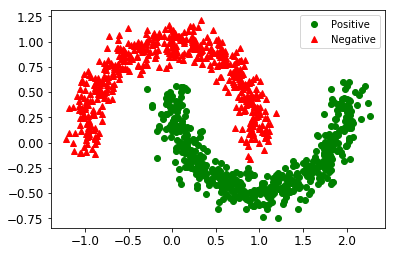

In [66]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

We must not forget to add an extra bias feature ($x_0 = 1$) to every instance. For this, we just need to add a column full of 1s on the left of the input matrix $\mathbf{X}$:

In [67]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

Let's check:

In [68]:
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

Looks good. Now let's reshape `y_train` to make it a column vector (i.e. a 2D array with a single column):

In [69]:
y_moons_column_vector = y_moons.reshape(-1, 1)

Now let's split the data into a training set and a test set:

In [70]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

Ok, now let's create a small function to generate training batches. In this implementation we will just pick random instances from the training set for each batch. This means that a single batch may contain the same instance multiple times, and also a single epoch may not cover all the training instances (in fact it will generally cover only about two thirds of the instances). However, in practice this is not an issue and it simplifies the code:

In [71]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

Let's look at a small batch:

In [72]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  1.93189866,  0.13158788],
       [ 1.        ,  1.07172763,  0.13482039],
       [ 1.        , -1.01148674, -0.04686381],
       [ 1.        ,  0.02201868,  0.19079139],
       [ 1.        , -0.98941204,  0.02473116]])

In [73]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

Great! Now that the data is ready to be fed to the model, we need to build that model. Let's start with a simple implementation, then we will add all the bells and whistles.

First let's reset the default graph.

In [113]:
reset_graph()

The _moons_ dataset has two input features, since each instance is a point on a plane (i.e., 2-Dimensional):

In [74]:
n_inputs = 2

Now let's build the Logistic Regression model. As we saw in chapter 4, this model first computes a weighted sum of the inputs (just like the Linear Regression model), and then it applies the sigmoid function to the result, which gives us the estimated probability for the positive class:

$\hat{p} = h_\mathbf{\theta}(\mathbf{x}) = \sigma(\mathbf{\theta}^T \cdot \mathbf{x})$


Recall that $\mathbf{\theta}$ is the parameter vector, containing the bias term $\theta_0$ and the weights $\theta_1, \theta_2, \dots, \theta_n$. The input vector $\mathbf{x}$ contains a constant term $x_0 = 1$, as well as all the input features $x_1, x_2, \dots, x_n$.

Since we want to be able to make predictions for multiple instances at a time, we will use an input matrix $\mathbf{X}$ rather than a single input vector. The $i^{th}$ row will contain the transpose of the $i^{th}$ input vector $(\mathbf{x}^{(i)})^T$. It is then possible to estimate the probability that each instance belongs to the positive class using the following equation:

$ \hat{\mathbf{p}} = \sigma(\mathbf{X} \cdot \mathbf{\theta})$

That's all we need to build the model:

In [75]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = 1 / (1 + tf.exp(-logits))

In fact, TensorFlow has a nice function `tf.sigmoid()` that we can use to simplify the last line of the previous code:

In [76]:
y_proba = tf.sigmoid(logits)

As we saw in chapter 4, the log loss is a good cost function to use for Logistic Regression:

$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$

One option is to implement it ourselves:

In [77]:
epsilon = 1e-7  # to avoid an overflow when computing the log
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))

But we might as well use TensorFlow's `tf.losses.log_loss()` function:

In [78]:
loss = tf.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

The rest is pretty standard: let's create the optimizer and tell it to minimize the cost function:

In [79]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

All we need now (in this minimal version) is the variable initializer:

In [80]:
init = tf.global_variables_initializer()

And we are ready to train the model and use it for predictions!

There's really nothing special about this code, it's virtually the same as the one we used earlier for Linear Regression:

In [81]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.792627
Epoch: 100 	Loss: 0.343456
Epoch: 200 	Loss: 0.307535
Epoch: 300 	Loss: 0.29289
Epoch: 400 	Loss: 0.285336
Epoch: 500 	Loss: 0.280476
Epoch: 600 	Loss: 0.27809
Epoch: 700 	Loss: 0.276155
Epoch: 800 	Loss: 0.275515
Epoch: 900 	Loss: 0.274917


Note: we don't use the epoch number when generating batches, so we could just have a single `for` loop rather than 2 nested `for` loops, but it's convenient to think of training time in terms of number of epochs (i.e., roughly the number of times the algorithm went through the training set).

For each instance in the test set, `y_proba_val` contains the estimated probability that it belongs to the positive class, according to the model. For example, here are the first 5 estimated probabilities:

In [82]:
y_proba_val[:5]

array([[ 0.54899573],
       [ 0.70736092],
       [ 0.51903737],
       [ 0.99111688],
       [ 0.50867587]], dtype=float32)

To classify each instance, we can go for maximum likelihood: classify as positive any instance whose estimated probability is greater or equal to 0.5:

In [83]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

Depending on the use case, you may want to choose a different threshold than 0.5: make it higher if you want high precision (but lower recall), and make it lower if you want high recall (but lower precision). See chapter 3 for more details.

Let's compute the model's precision and recall:

In [84]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.86274509803921573

In [85]:
recall_score(y_test, y_pred)

0.88888888888888884

Let's plot these predictions to see what they look like:

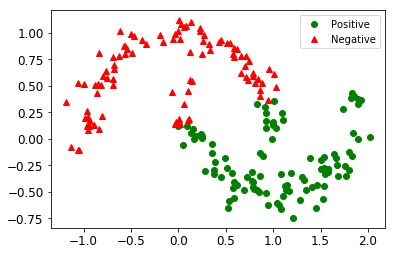

In [86]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Well, that looks pretty bad, doesn't it? But let's not forget that the Logistic Regression model has a linear decision boundary, so this is actually close to the best we can do with this model (unless we add more features, as we will show in a second).

Now let's start over, but this time we will add all the bells and whistles, as listed in the exercise:
* Define the graph within a `logistic_regression()` function that can be reused easily.
* Save checkpoints using a `Saver` at regular intervals during training, and save the final model at the end of training.
* Restore the last checkpoint upon startup if training was interrupted.
* Define the graph using nice scopes so the graph looks good in TensorBoard.
* Add summaries to visualize the learning curves in TensorBoard.
* Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

Before we start, we will add 4 more features to the inputs: ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ and ${x_2}^3$. This was not part of the exercise, but it will demonstrate how adding features can improve the model. We will do this manually, but you could also add them using `sklearn.preprocessing.PolynomialFeatures`.

In [87]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

This is what the "enhanced" training set looks like:

In [88]:
X_train_enhanced[:5]

array([[  1.00000000e+00,  -5.14696757e-02,   4.44198631e-01,
          2.64912752e-03,   1.97312424e-01,  -1.36349734e-04,
          8.76459084e-02],
       [  1.00000000e+00,   1.03201691e+00,  -4.19741157e-01,
          1.06505890e+00,   1.76182639e-01,   1.09915879e+00,
         -7.39511049e-02],
       [  1.00000000e+00,   8.67891864e-01,  -2.54827114e-01,
          7.53236288e-01,   6.49368582e-02,   6.53727646e-01,
         -1.65476722e-02],
       [  1.00000000e+00,   2.88850997e-01,  -4.48668621e-01,
          8.34348982e-02,   2.01303531e-01,   2.41002535e-02,
         -9.03185778e-02],
       [  1.00000000e+00,  -8.33439108e-01,   5.35056649e-01,
          6.94620746e-01,   2.86285618e-01,  -5.78924095e-01,
          1.53179024e-01]])

Ok, next let's reset the default graph:

In [89]:
reset_graph()

Now let's define the `logistic_regression()` function to create the graph. We will leave out the definition of the inputs `X` and the targets `y`. We could include them here, but leaving them out will make it easier to use this function in a wide range of use cases (e.g. perhaps we will want to add some preprocessing steps for the inputs before we feed them to the Logistic Regression model).

In [90]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

Let's create a little function to get the name of the log directory to save the summaries for Tensorboard:

In [91]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

Next, let's create the graph, using the `logistic_regression()` function. We will also create the `FileWriter` to save the summaries to the log directory for Tensorboard:

In [92]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

At last we can train the model! We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and continue training from the epoch number we saved. In this example we just save the epoch number to a separate file, but in chapter 11 we will see how to store the training step directly as part of the model, using a non-trainable variable called `global_step` that we pass to the optimizer's `minimize()` method.

You can try interrupting training to verify that it does indeed restore the last checkpoint when you start it again.

In [93]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.629985
Epoch: 500 	Loss: 0.161224
Epoch: 1000 	Loss: 0.119032
Epoch: 1500 	Loss: 0.0973292
Epoch: 2000 	Loss: 0.0836979
Epoch: 2500 	Loss: 0.0743758
Epoch: 3000 	Loss: 0.0675021
Epoch: 3500 	Loss: 0.0622069
Epoch: 4000 	Loss: 0.0580268
Epoch: 4500 	Loss: 0.054563
Epoch: 5000 	Loss: 0.0517083
Epoch: 5500 	Loss: 0.0492377
Epoch: 6000 	Loss: 0.0471673
Epoch: 6500 	Loss: 0.0453766
Epoch: 7000 	Loss: 0.0438187
Epoch: 7500 	Loss: 0.0423742
Epoch: 8000 	Loss: 0.0410892
Epoch: 8500 	Loss: 0.0399709
Epoch: 9000 	Loss: 0.0389202
Epoch: 9500 	Loss: 0.0380107
Epoch: 10000 	Loss: 0.0371557


Once again, we can make predictions by just classifying as positive all the instances whose estimated probability is greater or equal to 0.5:

In [134]:
y_pred = (y_proba_val >= 0.5)

In [135]:
precision_score(y_test, y_pred)

0.97979797979797978

In [136]:
recall_score(y_test, y_pred)

0.97979797979797978

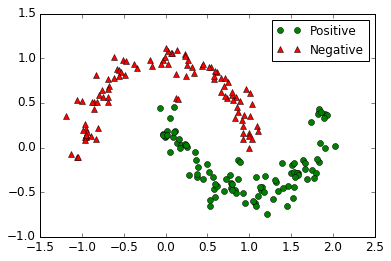

In [137]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Now that's much, much better! Apparently the new features really helped a lot.

Try starting the tensorboard server, find the latest run and look at the learning curve (i.e., how the loss evaluated on the test set evolves as a function of the epoch number):

```
$ tensorboard --logdir=tf_logs
```

Now you can play around with the hyperparameters (e.g. the `batch_size` or the `learning_rate`) and run training again and again, comparing the learning curves. You can even automate this process by implementing grid search or randomized search. Below is a simple implementation of a randomized search on both the batch size and the learning rate. For the sake of simplicity, the checkpoint mechanism was removed.

In [138]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

Iteration 0
  logdir: tf_logs/logreg-run-20170606195328/
  batch size: 19
  learning_rate: 0.00443037524522
  training: .....................
  precision: 0.979797979798
  recall: 0.979797979798
Iteration 1
  logdir: tf_logs/logreg-run-20170606195605/
  batch size: 80
  learning_rate: 0.00178264971514
  training: .....................
  precision: 0.969696969697
  recall: 0.969696969697
Iteration 2
  logdir: tf_logs/logreg-run-20170606195646/
  batch size: 73
  learning_rate: 0.00203228544324
  training: .....................
  precision: 0.969696969697
  recall: 0.969696969697
Iteration 3
  logdir: tf_logs/logreg-run-20170606195730/
  batch size: 6
  learning_rate: 0.00449152382514
  training: .....................
  precision: 0.980198019802
  recall: 1.0
Iteration 4
  logdir: tf_logs/logreg-run-20170606200523/
  batch size: 24
  learning_rate: 0.0796323472178
  training: .....................
  precision: 0.980198019802
  recall: 1.0
Iteration 5
  logdir: tf_logs/logreg-run-20170606

The `reciprocal()` function from SciPy's `stats` module returns a random distribution that is commonly used when you have no idea of the optimal scale of a hyperparameter. See the exercise solutions for chapter 2 for more details. 